# IMDb Datasets Analysis to Predict the Average Rating

                                                                                        Ziting Tang   08/25/2019

# Data Cleaning

In [49]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark 
from pyspark.sql import SparkSession
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor

There are seven datasets on https://www.imdb.com/interfaces/. Here I used three of them to analysize the average rating. The variable avreageRating is only included dataset TitleRatings.tsv. The other two data sets are joined with dataset TitleRatings.tsv according to the variable tconst, which is the alphanumeric unique identifier of the title.
Since the size of all data sets are very large. The PySpark package is used to read the datasets. 

In [2]:
spark = SparkSession.builder.getOrCreate()
#dfTitleBasics= spark.read.options(header='true', inferschema='true', delimiter='\t').csv("C:/Users/Ziting Tang/Desktop/Audible/TitleBasics.tsv")  
#dfTitleCrew = spark.read.options(header='true', inferschema='true', delimiter='\t').csv("C:/Users/Ziting Tang/Desktop/Audible/TitleCrew.tsv")  
#dfTitleRatings = spark.read.options(header='true', inferschema='true', delimiter='\t').csv("C:/Users/Ziting Tang/Desktop/Audible/TitleRatings.tsv") 
dfTitleBasics= spark.read.options(header='true', inferschema='true', delimiter='\t').csv("C:/Users/Kang/Desktop/Audible/TitleBasics.tsv")  
dfTitleCrew = spark.read.options(header='true', inferschema='true', delimiter='\t').csv("C:/Users/Kang/Desktop/Audible/TitleCrew.tsv")
dfTitleRatings = spark.read.options(header='true', inferschema='true', delimiter='\t').csv("C:/Users/Kang/Desktop/Audible/TitleRatings.tsv") 

From below, we can see all the variables from the combined dataset df: tconst, averageRating, numVotes, titleType, 
primaryTitle, originalTitle, isAdult, startYear, endYear, runtimeMinutes, genres, directors and writers. A '\N' is used to denote that a particular field is missing or null for that title/name. In Python, '\N' is represented by '\\\N'.

In [ ]:
df = dfTitleRatings.join(dfTitleBasics, on=['tconst'], how='left_outer').join(dfTitleCrew, on=['tconst'], how='left_outer')
df.show(5)

In [4]:
df.head()

Row(tconst='tt0000658', averageRating=6.4, numVotes=148, titleType='short', primaryTitle="The Puppet's Nightmare", originalTitle='Le cauchemar de Fantoche', isAdult=0, startYear='1908', endYear='\\N', runtimeMinutes='2', genres='Animation,Short', directors='nm0169871', writers='\\N')

In [5]:
data=df.toPandas()   # convert df in SparkSession to Pandas data frame
print(data.head())
data.info()

      tconst  averageRating  numVotes titleType                primaryTitle  \
0  tt0000658            6.4       148     short      The Puppet's Nightmare   
1  tt0001732            7.1         8     short       The Lighthouse Keeper   
2  tt0002253            4.2         5     short                  Home Folks   
3  tt0002473            6.8        57     short            The Sands of Dee   
4  tt0002588            6.8        10     short  Zigomar contre Nick Carter   

                originalTitle  isAdult startYear endYear runtimeMinutes  \
0    Le cauchemar de Fantoche        0      1908      \N              2   
1       The Lighthouse Keeper        0      1911      \N             \N   
2                  Home Folks        0      1912      \N             17   
3            The Sands of Dee        0      1912      \N             17   
4  Zigomar contre Nick Carter        0      1912      \N             18   

            genres  directors              writers  
0  Animation,Short  n

In [6]:
data.describe()

,averageRating,numVotes,isAdult
count,964364.000000,9.643640e+05,964364.000000
mean,6.890414,9.633980e+02,0.018691
std,1.401085,1.564202e+04,0.135432
min,1.000000,5.000000e+00,0.000000
25%,6.100000,9.000000e+00,0.000000
50%,7.100000,2.000000e+01,0.000000
75%,7.900000,7.700000e+01,0.000000
max,10.000000,2.125804e+06,1.000000


We can see that for three numeric variables averageRating, numVotes and isAdult, there are no missing values. They're all positive. There are no weird values.

In [9]:
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:6d}\t'.format(column, len(uniques)), uniques[:5])

tconst               964364	 ['tt0000001', 'tt0000002', 'tt0000003', 'tt0000004', 'tt0000005']
averageRating            91	 [1.0, 1.1, 1.2, 1.3, 1.4]
numVotes              17210	 [5, 6, 7, 8, 9]
titleType                10	 ['movie', 'short', 'tvEpisode', 'tvMiniSeries', 'tvMovie']
primaryTitle         742455	 ['!Next?', '!Women Art Revolution', '"#selfie" by The Chainsmokers', '"1 jikan buchi nuki de Sasuke ga ô abare dattebayo supesharu": Arashi o yobu otoko!! Sasuke no gejimayu-ryû taijutsu!', '"1 jikan buchi nuki de Sasuke ga ô abare dattebayo supesharu": Date ni okureta wake janai! Kyûkyoku ôgi - Chidori tanjô!!']
originalTitle        752860	 ['!Next?', '"#selfie" by The Chainsmokers', '"1 jikan buchi nuki de Sasuke ga ô abare dattebayo supesharu": Arashi o yobu otoko!! Sasuke no gejimayu-ryû taijutsu!', '"1 jikan buchi nuki de Sasuke ga ô abare dattebayo supesharu": Date ni okureta wake janai! Kyûkyoku ôgi - Chidori tanjô!!', '"1" More']
isAdult                   2	 [0, 1]
startY

From above, we can see the number of unique values for each variable and the first five unique values. There are no missing values for four variables tconst, averageRating, numVotes, isAdult. Since the unique values for variables tconst, primaryTitle and originalTitle are too large, these three variables won't be used in the model.

In [82]:
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:6d}\t'.format(column, len(uniques)), uniques[:2])

tconst               964364	 ['tt0000001', 'tt0000002']
averageRating            91	 [1.0, 1.1]
numVotes              17210	 [5, 6]
titleType                10	 ['movie', 'short']
primaryTitle         742455	 ['!Next?', '!Women Art Revolution']
originalTitle        752860	 ['!Next?', '"#selfie" by The Chainsmokers']
isAdult                   2	 [0, 1]
startYear               139	 ['1874', '1878']
endYear                  76	 ['1927', '1933']
runtimeMinutes          658	 ['0', '1']
genres                 1945	 ['Action', 'Action,Adult']
directors            236346	 ['\\N', 'nm0000005']
writers              410926	 ['\\N', 'nm0000005']


In [45]:
print(data[data["titleType"]=='\\N'].shape[0]) #0
print(data[data["primaryTitle"]=='\\N'].shape[0]) #0
print(data[data["originalTitle"]=='\\N'].shape[0]) #3
print(data[data["startYear"]=='\\N'].shape[0]) # 109
print(data[data["endYear"]=='\\N'].shape[0]) # 943583
print(data[data["runtimeMinutes"]=='\\N'].shape[0]) # 262733
print(data[data["genres"]=='\\N'].shape[0]) # 22978


0
0
3
109
943583
262733
22978


There is no missing value for variable titleType. The number of missing values for variable endYear is 943583. Almost all are missing values for endYear, so drop endYear.

In [8]:
for column in data.columns:
    NMissing=data[data[column]=='\\N'].shape[0]
    print('{0:20s}{1:6d}'.format(column,NMissing))

tconst                   0
averageRating            0
numVotes                 0
titleType                0
primaryTitle             0
originalTitle            3
isAdult                  0
startYear              109
endYear             943583
runtimeMinutes      262733
genres               22978
directors           136689
writers             211281


In [87]:
for column in data.columns:
    if column not in ['tconst', 'primaryTitle', 'originalTitle']:
        NMissing=data[data[column]=='\\N'].shape[0]
        print('{0:20s}{1:6d}'.format(column,NMissing))

averageRating            0
numVotes                 0
titleType                0
isAdult                  0
startYear              109
endYear             943583
runtimeMinutes      262733
genres               22978
directors           136689
writers             211281


(array([309056.,  66459.,  49243.,  52392.,  45002.,  30705.,  46655.,
         57803.,  43132.,  10647.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

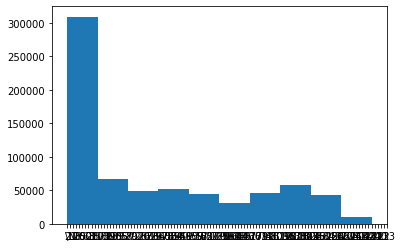

In [91]:
plt.hist(data['runtimeMinutes'], range=[0,100])

In [9]:
print(data["directors"].value_counts(dropna=False).head(10))
print(data["writers"].value_counts(dropna=False).head(10))

\N                     136689
nm1337210                2848
nm3766090                1085
nm0123273                 910
nm2078274                 645
nm3005544                 635
nm0842611                 594
nm1121649                 563
nm0053484,nm0360253       561
nm0669120                 555
Name: directors, dtype: int64
\N                               211281
nm3005544                           865
nm3766090                           862
nm1108327                           861
nm0868066                           752
nm1444457                           670
nm0663789                           599
nm2095966,nm2242949,nm0846969       595
nm1121649                           586
nm0242472                           554
Name: writers, dtype: int64


There's not enough information for missing directors and writers. It is not appropriate to impute missing values with the mode. 
For valid directors and writers, the number for each category are less than 3000. The largest numbers are 2848 and 865 for directors and writers, respectively. But for missing values, the numbers are 136689 and 211281 for directors and writers, respectively. There are too many missing values. It is not appropriate to treat them as separate category and use them as a different level. For simplicity, rows/observations of the data with missing directors and writers will be dropped. 

Currently, the varaibles averageRating, numVotes, titleType, isAdult, startYear, runtimeMinutes, genres, directors and writers are kept in the data set.  

In [50]:
print(data["genres"].value_counts(dropna=False).head(10))

Comedy                        86941
Drama                         72781
Documentary                   53645
Action,Adventure,Animation    24208
\N                            22978
Reality-TV                    20416
Short                         19371
Comedy,Drama                  18403
Drama,Romance                 18335
Crime,Drama,Mystery           18056
Name: genres, dtype: int64


In [51]:
movie=data[[ 'averageRating','numVotes', 'titleType' , 'isAdult','startYear' , 'runtimeMinutes' ,'genres' ,'directors' ,'writers']]
movie=movie[movie["directors"]!='\\N']
movie=movie[movie["writers"]!='\\N']

movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708102 entries, 2 to 964363
Data columns (total 9 columns):
averageRating     708102 non-null float64
numVotes          708102 non-null int32
titleType         708102 non-null object
isAdult           708102 non-null int32
startYear         708102 non-null object
runtimeMinutes    708102 non-null object
genres            708102 non-null object
directors         708102 non-null object
writers           708102 non-null object
dtypes: float64(1), int32(2), object(6)
memory usage: 48.6+ MB


In [134]:
movie.loc[movie['runtimeMinutes']=='\\N','runtimeMinutes']="NaN"
movie['runtimeMinutes']=movie['runtimeMinutes'].astype(str).astype(float) #convert to an integer.
#movie['runtimeMinutes']=pd.to_numeric(movie['runtimeMinutes']) # same method

Change the type of variable runtimeMinutes from object to float only after the missing value symbol '\\N' is replaced by np.nan, i.e., NaN.

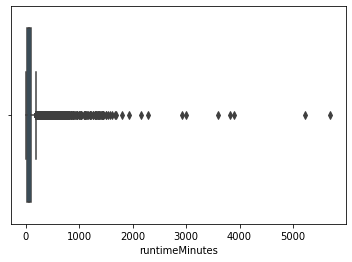

In [29]:
#movie.boxplot(column='runtimeMinutes')

sns.boxplot(movie['runtimeMinutes'])
from scipy import stats

#z = np.abs(stats.zscore(movie['runtimeMinutes']))
#print(z)
#print(np.where(z > 3))

In [30]:
movie.info() # check the type
print(movie.describe())
print(movie[movie['runtimeMinutes']>2000])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708102 entries, 2 to 964363
Data columns (total 9 columns):
averageRating     708102 non-null float64
numVotes          708102 non-null int32
titleType         708102 non-null object
isAdult           708102 non-null int32
startYear         708102 non-null object
runtimeMinutes    557240 non-null float64
genres            708102 non-null object
directors         708102 non-null object
writers           708102 non-null object
dtypes: float64(2), int32(2), object(5)
memory usage: 48.6+ MB
       averageRating      numVotes        isAdult  runtimeMinutes
count  708102.000000  7.081020e+05  708102.000000   557240.000000
mean        6.876295  1.292878e+03       0.009586       58.656832
std         1.376301  1.824053e+04       0.097439       46.626703
min         1.000000  5.000000e+00       0.000000        0.000000
25%         6.100000  1.000000e+01       0.000000       24.000000
50%         7.100000  2.700000e+01       0.000000       50.000

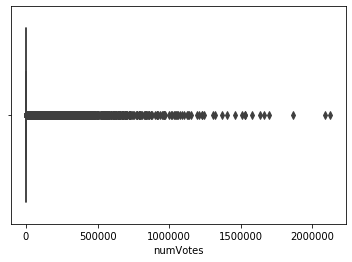

In [12]:
sns.boxplot(movie['numVotes'])
from scipy import stats

In [13]:
print(movie[movie['numVotes']>1500000])

        averageRating  numVotes titleType  isAdult startYear  runtimeMinutes  \
265538            8.9   1512396     movie        0      2003           201.0   
267507            8.8   1863870     movie        0      2010           148.0   
386949            9.0   2090684     movie        0      2008           152.0   
410436            8.8   1699242     movie        0      1999           139.0   
615008            9.4   1578917  tvSeries        0      2011            57.0   
632566            9.3   2125804     movie        0      1994           142.0   
675916            8.8   1527976     movie        0      2001           178.0   
767300            8.9   1665976     movie        0      1994           154.0   
931106            8.8   1634956     movie        0      1994           142.0   
950485            8.7   1529460     movie        0      1999           136.0   

                         genres  \
265538  Adventure,Drama,Fantasy   
267507  Action,Adventure,Sci-Fi   
386949       A

Check if the observations with too large runtimeMinutes are outliers: The title of most movies with run time larger than 2000 min is tvSeries and video. This makes sense. These observations will not be considered as outliers. Impute the missing values of variable runtimeMinutes with median.

In [135]:
median = movie['runtimeMinutes'].median()
movie['runtimeMinutes'].fillna(median, inplace = True) 

In [136]:
print(movie.columns.values)
print(movie.columns)
labels=movie["averageRating"]# get the response varible
numeric_features=movie.loc[:, movie.columns != "averageRating"]._get_numeric_data().columns.values.tolist()# get numeric features
print(numeric_features)
movie.describe()

['averageRating' 'numVotes' 'titleType' 'isAdult' 'startYear'
 'runtimeMinutes' 'genres' 'directors' 'writers']
Index(['averageRating', 'numVotes', 'titleType', 'isAdult', 'startYear',
       'runtimeMinutes', 'genres', 'directors', 'writers'],
      dtype='object')
['numVotes', 'isAdult', 'runtimeMinutes']


,averageRating,numVotes,isAdult,runtimeMinutes
count,708102.000000,7.081020e+05,708102.000000,708102.000000
mean,6.876295,1.292878e+03,0.009586,56.812483
std,1.376301,1.824053e+04,0.097439,41.514208
min,1.000000,5.000000e+00,0.000000,0.000000
25%,6.100000,1.000000e+01,0.000000,30.000000
50%,7.100000,2.700000e+01,0.000000,50.000000
75%,7.800000,1.170000e+02,0.000000,84.000000
max,10.000000,2.125804e+06,1.000000,5700.000000


In [137]:
categorical_features=['titleType', 'startYear','genres', 'directors', 'writers']
numeric_features.remove("isAdult") 
categorical_features.append("isAdult") #get categorical features
print(numeric_features)
print(categorical_features)

['numVotes', 'runtimeMinutes']
['titleType', 'startYear', 'genres', 'directors', 'writers', 'isAdult']


In [37]:
print(movie['titleType'].value_counts())
print(movie['directors'].value_counts())
print(movie["isAdult"].value_counts())

tvEpisode       296809
movie           207445
short            88968
tvSeries         43709
tvMovie          34053
video            21135
tvMiniSeries      6986
tvSpecial         3788
videoGame         3055
tvShort           2154
Name: titleType, dtype: int64
nm1337210                                                                                                                                                                                                                                                                                                                                                                                                                                        2842
nm3766090                                                                                                                                                                                                                                                                                                     

In [138]:
movie[categorical_features]=movie[categorical_features].astype('str') 
print(numeric_features)
print(categorical_features)
movie["isAdult"]=movie["isAdult"].astype('int') 

['numVotes', 'runtimeMinutes']
['titleType', 'startYear', 'genres', 'directors', 'writers', 'isAdult']


In [42]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708102 entries, 2 to 964363
Data columns (total 9 columns):
averageRating     708102 non-null float64
numVotes          708102 non-null int32
titleType         708102 non-null object
isAdult           708102 non-null int32
startYear         708102 non-null object
runtimeMinutes    708102 non-null float64
genres            708102 non-null object
directors         708102 non-null object
writers           708102 non-null object
dtypes: float64(2), int32(2), object(5)
memory usage: 48.6+ MB


In [40]:
print(movie["startYear"].value_counts())
print(movie["genres"].value_counts())

2016    31634
2017    30558
2015    30418
2014    28923
2013    28621
        ...  
1899        8
1904        8
1902        7
1895        6
1894        3
Name: startYear, Length: 127, dtype: int64
Comedy                        76241
Drama                         65396
Documentary                   23820
Comedy,Drama                  17477
Crime,Drama,Mystery           17468
                              ...  
Adventure,History,Thriller        1
Family,History,Sci-Fi             1
Adventure,Biography,Horror        1
Adult,Animation,Thriller          1
Fantasy,Horror,War                1
Name: genres, Length: 1803, dtype: int64


The number of missing values for variables startYear and genresis small. The most frequent method is used to impute the missing values of category variables. From above result, we can see that the most frequent categories for variables startYear and genresis are '2016' and 'Comedy'.

In [139]:
movie.loc[movie["startYear"]=='\\N',"startYear"]=2016
movie.loc[movie["genres"]=='\\N',"genres"]="Comedy"
movie["startYear"]=movie["startYear"].astype(int)

In [140]:
movie[categorical_features]=movie[categorical_features].astype('category')  


In [ ]:
movie.info()

In [ ]:
 #This is the same most frequent impution method as above, but using SimpleImputer function. This will take longer time to operate.
#imp=SimpleImputer(missing_values='\\N',strategy="most_frequent") #Number of missing values is small. The most frequent method is used to impute the missing values of category variables.
#movie[['startYear', 'genres']]=imp.fit_transform(movie[['startYear', 'genres']])

In [ ]:
print(data[data["titleType"]=='\\N'].shape[0]) #0
print(data[data["primaryTitle"]=='\\N'].shape[0]) #0
print(data[data["originalTitle"]=='\\N'].shape[0]) #3
print(data[data["startYear"]=='\\N'].shape[0]) # 109
print(data[data["endYear"]=='\\N'].shape[0]) # 943583
print(data[data["runtimeMinutes"]=='\\N'].shape[0]) # 262733
print(data[data["genres"]=='\\N'].shape[0]) # 22978

In [12]:
movie.info()
print(movie.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708102 entries, 2 to 964363
Data columns (total 9 columns):
averageRating     708102 non-null float64
numVotes          708102 non-null int32
titleType         708102 non-null category
isAdult           708102 non-null category
startYear         708102 non-null category
runtimeMinutes    557240 non-null float64
genres            708102 non-null category
directors         708102 non-null category
writers           708102 non-null category
dtypes: category(6), float64(2), int32(1)
memory usage: 52.4 MB
       averageRating      numVotes  runtimeMinutes
count  708102.000000  7.081020e+05   557240.000000
mean        6.876295  1.292878e+03       58.656832
std         1.376301  1.824053e+04       46.626703
min         1.000000  5.000000e+00        0.000000
25%         6.100000  1.000000e+01       24.000000
50%         7.100000  2.700000e+01       50.000000
75%         7.800000  1.170000e+02       90.000000
max        10.000000  2.125804e+06  

# Data Visualization

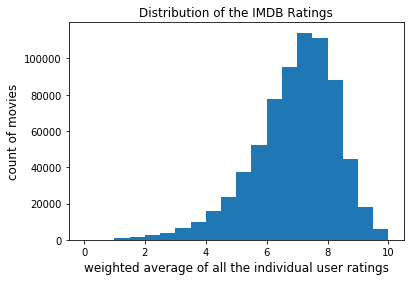

In [124]:
plt.hist(labels,bins=20,  range=[0, 10]) 
plt.title("Distribution of the IMDB Ratings")
plt.xlabel('weighted average of all the individual user ratings', fontsize=12)
plt.ylabel('count of movies', fontsize=12)
plt.show()

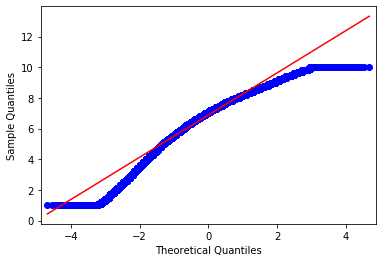

In [45]:
from statsmodels.graphics.gofplots import qqplot
qqplot(labels, line='s')
plt.show()

In [41]:
from scipy import stats
k2, p = stats.normaltest(labels)
print((k2,p))

(73424.03401114198, 0.0)


From above histogram, we can see that most of the average ratings fall betweeen 6 and 9. Most of people are satisfied with the movies they saw. The distribution of the average ratings is a little left skewed. It is kind of bell shaped, but not symmetric. The averageRating variable doesn't follow the normal distribution exactly. 

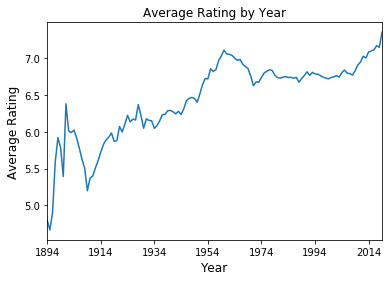

In [125]:
movie.groupby('startYear')['averageRating'].mean().plot()
plt.title('Average Rating by Year')
plt.ylabel('Average Rating', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.show()

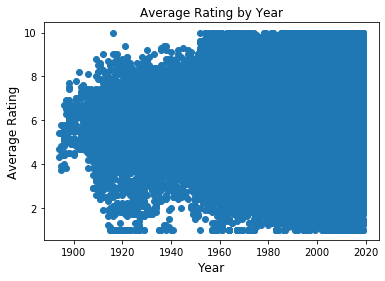

In [126]:
plt.scatter(movie['startYear'],movie['averageRating'])
plt.title('Average Rating by Year')
plt.ylabel('Average Rating', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.show()

From above, we can see that the group mean of the average rating is kind of increasing with the year. The average rating is significantly time related. This will be further analysed if there is enough time. 

In [25]:
movie.groupby('isAdult')['averageRating'].mean()

isAdult
0    6.883403
1    6.142001
Name: averageRating, dtype: float64

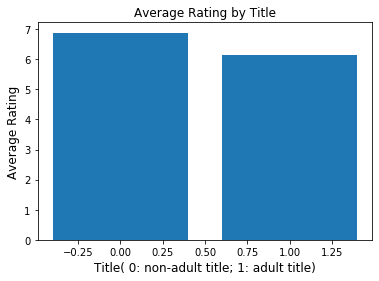

In [127]:
# Visualization of adult
plt.bar([0,1],movie.groupby('isAdult')['averageRating'].mean())
plt.title('Average Rating by Title')
plt.ylabel('Average Rating', fontsize=12)
plt.xlabel('Title( 0: non-adult title; 1: adult title)', fontsize=12)
plt.show()

From above, we can see that the non-adult title tends to get higher average rating.

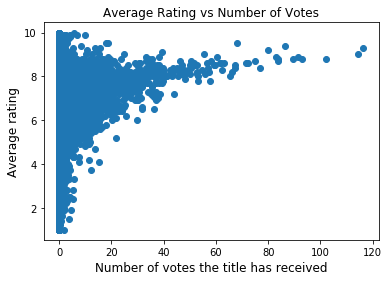

In [128]:
plt.scatter('numVotes','averageRating',data=movie)
plt.title('Average Rating vs Number of Votes')
plt.ylabel('Average rating', fontsize=12)
plt.xlabel('Number of votes the title has received', fontsize=12)
plt.show()

There is an increasing trend between variables numVotes and averageRating. But it is not linear, kind of quadratic.

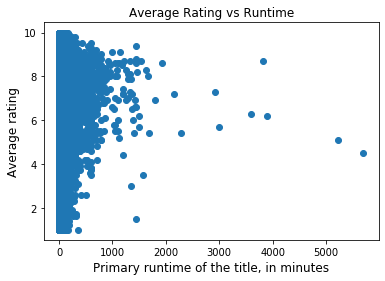

In [28]:
plt.scatter('runtimeMinutes','averageRating',data=movie)
plt.title('Average Rating vs Runtime')
plt.ylabel('Average rating', fontsize=12)
plt.xlabel('Primary runtime of the title, in minutes', fontsize=12)
plt.show() 

There is no linear trend between runtimeMinutes and averageRating.

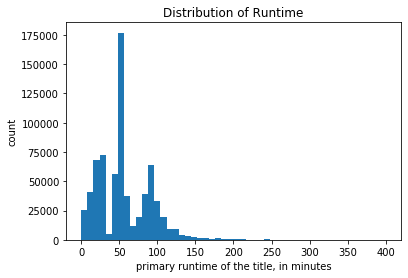

In [142]:
plt.hist(movie['runtimeMinutes'],bins=50,  range=[0, 400])
plt.title("Distribution of Runtime")
plt.xlabel('primary runtime of the title, in minutes')
plt.ylabel('count')
plt.show()

In [132]:
movie['runtimeMinutes']

2        -0.959009
3        -0.959009
4        -0.934921
5        -0.983097
6         5.857939
            ...   
964356   -0.164100
964357    0.919867
964358   -0.164100
964360   -0.164100
964363   -0.814480
Name: runtimeMinutes, Length: 708102, dtype: float64

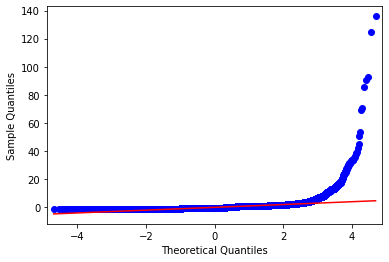

In [130]:
qqplot(movie['runtimeMinutes'], line='s')
plt.show()

In [42]:
from scipy import stats
k2, p = stats.normaltest(movie['runtimeMinutes'])
print((k2,p))

(1410765.9757373123, 0.0)


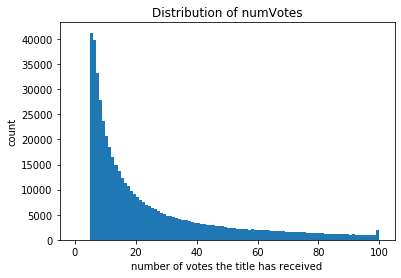

In [143]:
plt.hist(movie['numVotes'],bins=100,  range=[0, 100])
plt.title("Distribution of numVotes")
plt.xlabel('number of votes the title has received')
plt.ylabel('count')
plt.show()

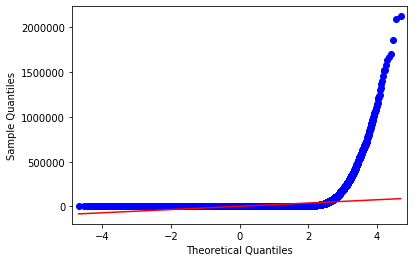

In [47]:
qqplot(movie['numVotes'], line='s')
plt.show()

In [43]:
k2, p = stats.normaltest(movie['numVotes'])
print((k2,p))

(2056586.7563428297, 0.0)


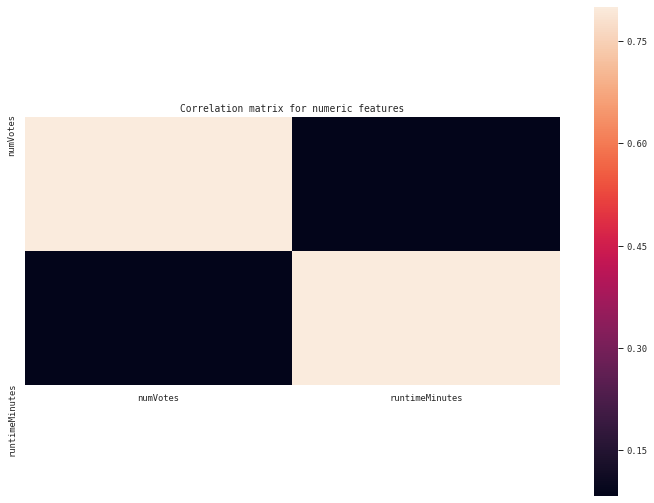

In [30]:
def corrmap(features, title):
    sns.set(context="paper", font="monospace")
    corrmat = movie[features].corr()
    f, ax = plt.subplots(figsize=(12, 9))
    plt.title(title)
    # Draw the heatmap using seaborn
    sns.heatmap(corrmat, vmax=.8, square=True)
corrmap(numeric_features,"Correlation matrix for numeric features")

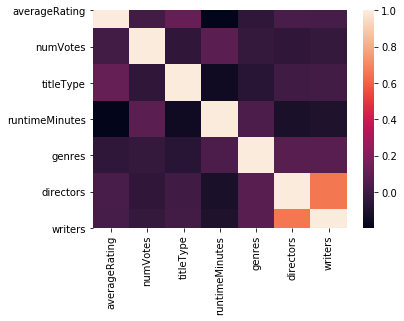

In [116]:
  sns.heatmap(movie.corr(), square=True)

In [30]:
corrmat = movie[numeric_features].corr()
corrmat 

,numVotes,runtimeMinutes
numVotes,1.000000,0.083436
runtimeMinutes,0.083436,1.000000


In [110]:
movie.corr()

,averageRating,numVotes,titleType,runtimeMinutes,genres,directors,writers
averageRating,1.000000,0.016248,0.119521,-0.198570,-0.051966,0.033634,0.025550
numVotes,0.016248,1.000000,-0.044594,0.083436,-0.032732,-0.045299,-0.033923
titleType,0.119521,-0.044594,1.000000,-0.148712,-0.070253,0.006348,0.012216
runtimeMinutes,-0.198570,0.083436,-0.148712,1.000000,0.041935,-0.117944,-0.102625
genres,-0.051966,-0.032732,-0.070253,0.041935,1.000000,0.079428,0.073068
directors,0.033634,-0.045299,0.006348,-0.117944,0.079428,1.000000,0.658989
writers,0.025550,-0.033923,0.012216,-0.102625,0.073068,0.658989,1.000000


There is almost no correlation between variables numVotes and runtimeMinutes.

In [31]:
import operator
from scipy.stats import pearsonr
correl={}
for f in numeric_features:
    correl[f]=pearsonr(movie[f], labels)
sorted_cor = sorted(correl.items(), key=operator.itemgetter(1), reverse=True)
print (sorted_cor)

[('numVotes', (0.016247686388758377, 1.469748170029789e-42)), ('runtimeMinutes', (-0.19857033119223186, 0.0))]


The Pearson correlation coefficient beween numVotes and averageRating is 0.016247686388757378. The Pearson correlation coefficient beween runtimeMinutes and averageRating is -0.1985703311921796. They're all very small. There is not obvious linear relationship between averageRating and these two variables.

# Data Preparation

The variable isAdult is already dummy variable. The rest categorical variables titleType, startYear,genres, directors, writers need to be recoded. Here the LabelEncoder is used. I prefer OneHotEncoder method, but there exists memory problem. There're two methods for the one hot encoder, one is get_dummies, the other is OneHotEncoder. 

In [38]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [39]:
movie=MultiColumnLabelEncoder(columns = ['titleType', 'genres', 'directors', 'writers']).fit_transform(movie)

In [107]:
#mov = movie.copy()
#for feat in categorical_features:
#    mov=pd.concat([mov, pd.get_dummies(mov[feat], prefix=feat, dummy_na=True)],axis=1)

In [108]:
import gc
#del [[dfTitleRatings,dfTitleBasics,dfTitleCrew]] ##need to be a list
#del[[movie_onehot]]
#del[[mov]]
gc.collect()


183

In [35]:
# TODO: create a OneHotEncoder object, and fit it to all of X

# 1. INSTANTIATE
#enc = OneHotEncoder(sparse=True,categories='auto')
#enc=LabelEncoder()
# 2. FIT
#enc.fit_transform(movie[categorical_features])
# 3. Transform
#onehotlabels = enc.transform(movie[categorical_features]).toarray()
#onehotlabels.shape

For numeric features, do the standardized transformation. This is necessary for advanced modeling, like distance based algorithm. If there is additional time, this part can be explored.

In [51]:
scl=StandardScaler()
movie[numeric_features]=scl.fit_transform(movie[numeric_features])
movie[numeric_features].head() 

,numVotes,runtimeMinutes
2,-0.070605,-0.959009
3,-0.067755,-0.959009
4,-0.070331,-0.934921
5,-0.023458,-0.983097
6,-0.070386,5.857939


In [37]:
movie.describe()
movie.head()

,averageRating,numVotes,titleType,isAdult,startYear,runtimeMinutes,genres,directors,writers
2,4.2,-0.070605,1,0,1912,-0.959009,1392,278,208384
3,6.8,-0.067755,1,0,1912,-0.959009,1759,278,128580
4,6.8,-0.070331,1,0,1912,-0.934921,1782,35716,120687
5,5.1,-0.023458,1,0,1914,-0.983097,1017,52523,382
6,5.8,-0.070386,0,0,1914,5.857939,0,24870,66689


In [ ]:
mov=movie.copy()
scl=StandardScaler()
movie[numeric_features]=scl.fit_transform(movie[numeric_features])
movie[numeric_features].head() 

# Build Models

Although the linear regression assumptions are not satisfied, the linear regression is still built to do comparision with other models.

In [111]:
### Linear Model

X=movie.loc[:, movie.columns != "averageRating"]
y=labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) #split data set

lr = LinearRegression(normalize=True)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
#print(lr.score(X_train,y_train))
print(lr.score(X_test,y_test))
print(r2_score(y_test,y_pred))
# calculate RMSE using scikit-learn
print(np.sqrt(mean_squared_error(y_test,y_pred)))

0.06129688211190187
0.061296882111901874
1.3405029634062784


We can see that the R square is 0.060365792914010674. It is very small. It confirms the previous conclusion: the linear relationship doesn't exist. But the The Root Mean Squared Error  is 1.3405029634062784. It is small. Although the linear regression doesn't fit well, it can predict pretty good average rating.

Text(0, 0.5, 'residules')

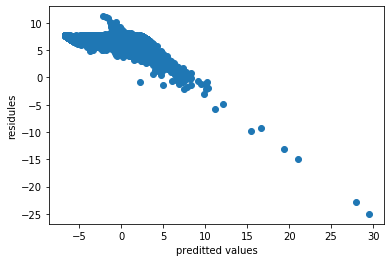

In [113]:
y_pred_train=lr.predict(X_train)
residual = y_train- y_pred_train
_ = plt.scatter(residual, y_pred_train)
plt.xlabel('preditted values')
plt.ylabel('residules')

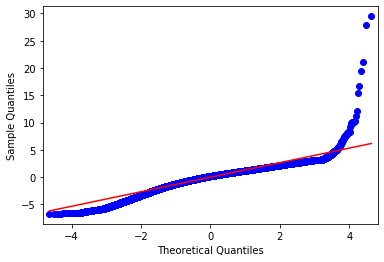

In [114]:
qqplot(residual, line='s')
plt.show()

In [39]:
# print the intercept and coefficients
print(lr.intercept_)
print(lr.coef_)

-4.542829243829906
[ 4.17491430e-02  6.67870102e-02 -8.90849834e-01  5.75778219e-03
 -2.37160353e-01 -1.32003442e-04 -1.75939157e-07 -2.86377211e-07]


In [58]:
## Polynomial Regression

XPol= PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_train)
lrPol = LinearRegression().fit(XPol, y_train)

In [59]:
XPolT= PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_test)
y_pred = lrPol.predict(XPolT)
print(lrPol.score(XPol,y_train))
print(r2_score(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

0.1443656802348655
0.14507144355839208
1.2792886890811008


The Root Mean Squared Error is 1.2792886890811008. It is smaller than 1.3405029634062784. This model is a little improved compared to the previous linear regression. 

Since Decision Tree and Random Forest can capture non-linear relationship well, I wil fit these two models to see if better prediction can be achieved.

In [105]:
## Decision Tree Regression

regressor = DecisionTreeRegressor( min_samples_leaf=0.15,random_state = 1)  # create a regressor object 
regressor.fit(X_train, y_train) # fit the regressor 

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.15,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [96]:
y_pred = regressor.predict(X_test) 
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

,Actual,Predicted
850479,7.7,7.8
412095,8.2,8.5
838616,7.6,7.5
706338,8.5,8.0
390848,7.8,7.5
...,...,...
722934,7.4,7.7
949893,8.3,9.5
92668,5.9,6.0
289387,6.8,5.7


We can see that the predicted value and the actural value are not so far away with each other.

In [106]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.9571484252278255
Mean Squared Error: 1.5994051810676255
Root Mean Squared Error: 1.2646759193831538


The Root Mean Squared Error is 1.4109823340941219. It is close to the the corresponing values in the previous models.

In [103]:
# Instantiate dt
dt = DecisionTreeRegressor(max_depth=8,
             min_samples_leaf=0.15,
            random_state=1)

# Fit dt to the training set
dt.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.15,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [104]:
# Compute y_pred
y_pred =dt.predict(X_test)

# Compute mse_dt
mse_dt=mean_squared_error(y_test,y_pred)

# Compute rmse_dt
rmse_dt=mse_dt**(0.5)
##### No sqrt
# Print rmse_dt
print("Test set RMSE of dt: {:f}".format(rmse_dt))

Test set RMSE of dt: 1.264676


In [73]:
from sklearn.model_selection import cross_val_score 
# Compute the array containing the 10-folds CV MSEs
MSE_CV_scores = - cross_val_score(dt,X_train,y_train, cv=10, 
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(0.5)
#### mean()

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

CV RMSE: 1.26


In [74]:
# Fit dt to the training set
dt.fit(X_train,y_train)

# Predict the labels of the training set
y_pred_train = dt.predict(X_train)

# Evaluate the training set RMSE of dt
RMSE_train = (mean_squared_error(y_train,y_pred_train))**(0.5)

# Print RMSE_train
print('Train RMSE: {:.2f}'.format(RMSE_train))

Train RMSE: 1.26


In [79]:
## Random Forest Regression

rf = RandomForestRegressor(n_estimators = 50, random_state = 2) # Instantiate model with 50 decision trees
rf.fit(X_train, y_train) # Train the model on training data

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=2, verbose=0,
                      warm_start=False)

In [80]:
predictions = rf.predict(X_test) # Use the forest's predict method on the test data
errors = abs(predictions - y_test) # Calculate the absolute errors
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.72
Root Mean Squared Error: 1.0262960327587543


The Root Mean Squared Error is 1.4109823340941219. It gets the same accuracy as the decision tree regression.

In [48]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 87.07 %.


The accuracy is 87.07 %. The model predicts pretty well.

In [75]:
# Instantiate rf
rf = RandomForestRegressor(n_estimators=25,
            random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train,y_train) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=2, verbose=0,
                      warm_start=False)

In [76]:
# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test =mean_squared_error(y_test,y_pred)**0.5

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 1.03


In [93]:
print('Root Mean Squared Error:{:.6f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

Root Mean Squared Error:1.026296


In [94]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df.head()

,Actual,Predicted
850479,7.7,7.832
412095,8.2,8.348
838616,7.6,7.684
706338,8.5,7.192
390848,7.8,7.504


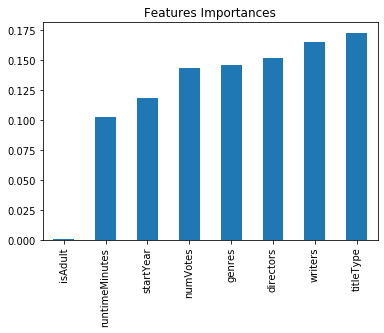

In [78]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()
### sort_values() NOT sorted_values
# Draw a horizontal barplot of importances_sorted
#importances_sorted.plot(kind='barh', color ='lightgreen')
importances_sorted.plot(kind='bar')
plt.title('Features Importances')
plt.show()

# Future Work

If there are additional time, I would like to explore the rest data sets among those seven data sets on IMDb website. When cleaning the data, I saw that the variable genres has more specific descriptions. They are strings separated by comma. Next time, I can split genres into several variable, then create a few more categorical variables. For recoding part, I wonder if model will be improved when one hot encoder is used instead of the label encoder. For model buiding part, I would like to try machine learning pipeline. I think this can produce more complex models and give better prediction.